# 2 Model Train
- 使用CV方法做训练

In [25]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Concatenate, Attention
from tensorflow.keras.callbacks import ModelCheckpoint
import sklearn.metrics as sm

In [26]:
DATA_PATH = "data_add_test.json"
def load_data(data_path):
    """Loads training dataset from json file
    
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def prepare_datasets(test_size, validation_size):
    
    # load data
    X, y = load_data(DATA_PATH)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validation_size)
    
    return (X_train, X_validation, X_test, y_train, y_validation, y_test)

    
def plot_history(history):
    
    fig, axs = plt.subplots(2)
    plt.figure(dpi=450)
    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label = "train accuracy")
    axs[0].plot(history.history["val_accuracy"], label = "test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("Accuracy eval")
    
    # create accuracy subplot
    axs[1].plot(history.history["loss"], label = "train error")
    axs[1].plot(history.history["val_loss"], label = "test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("Error eval")
    
    plt.show()
    
def predict(model, X, y):
    
    X = X[np.newaxis, ...]
    
    # prediction = [ [0.1, 0.2, ...]]
    prediction = model.predict(X) # X -> (1, 130, 13, 1)
    
    # extract index with max value
    predicted_index = np.argmax(prediction, axis = 1) #[4]
    print("Expected index: {}, Predicted index: {}".format(y,  predicted_index))

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, LayerNormalization, MultiHeadAttention, Dropout, Add, Flatten, GlobalAveragePooling1D
from tensorflow.keras.models import Model



# 创建 ViT 模型
def create_vit_classifier(input_shape, num_classes, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units):
    # 输入层
    inputs = Input(shape=input_shape)
    #     print(f"输入层尺寸: {inputs.shape}")  # 输入层尺寸: (?, 130, 13)
    
    # 将输入分割成 patches
    patches = tf.keras.layers.Reshape((num_patches, patch_size * input_shape[-1]))(inputs)
    #     print(f"patches尺寸: {patches.shape}")  # patches尺寸: (?, 10, 169)
    
    # Patch projection
    x = Dense(units=projection_dim)(patches)
    #     print(f"Patch projection尺寸: {x.shape}")  # Patch projection尺寸: (?, 10, 64)
    x = LayerNormalization(epsilon=1e-6)(x)
    #     print(f"LayerNormalization后尺寸: {x.shape}")  # LayerNormalization后尺寸: (?, 10, 64)
    x = Dropout(0.1)(x)
    #     print(f"Dropout后尺寸: {x.shape}")  # Dropout后尺寸: (?, 10, 64)
    
    # Transformer blocks
    for _ in range(transformer_layers):
        # Multi-head attention and skip connection
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x, x)
        #         print(f"MultiHeadAttention后尺寸: {attention_output.shape}")  # MultiHeadAttention后尺寸: (?, 10, 64)
        attention_output = Add()([attention_output, x])
        #         print(f"Add后尺寸: {attention_output.shape}")  # Add后尺寸: (?, 10, 64)
        attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
        #         print(f"LayerNormalization后尺寸: {attention_output.shape}")  # LayerNormalization后尺寸: (?, 10, 64)
        
        # Feedforward network and skip connection
        ffn_output = Dense(units=transformer_units[0], activation="relu")(attention_output)
        #         print(f"Feedforward network后尺寸: {ffn_output.shape}")  # Feedforward network后尺寸: (?, 10, 128)
        ffn_output = Dense(units=projection_dim)(ffn_output)
        #         print(f"Dense后尺寸: {ffn_output.shape}")  # Dense后尺寸: (?, 10, 64)
        ffn_output = Dropout(0.1)(ffn_output)
        #         print(f"Dropout后尺寸: {ffn_output.shape}")  # Dropout后尺寸: (?, 10, 64)
        ffn_output = Add()([ffn_output, attention_output])
        #         print(f"Add后尺寸: {ffn_output.shape}")  # Add后尺寸: (?, 10, 64)
        x = LayerNormalization(epsilon=1e-6)(ffn_output)
        #         print(f"LayerNormalization后尺寸: {x.shape}")  # LayerNormalization后尺寸: (?, 10, 64)
    
    # Representation layer
    representation = GlobalAveragePooling1D()(x)
    #     print(f"GlobalAveragePooling1D后尺寸: {representation.shape}")  # GlobalAveragePooling1D后尺寸: (?, 64)
    
    # MLP head
    for units in mlp_head_units:
        representation = Dense(units=units, activation="relu")(representation)
        #         print(f"Dense后尺寸: {representation.shape}")  # Dense后尺寸: (?, 64) 或 (?, 32) 取决于当前层

    # 分类层
    outputs = Dense(units=num_classes, activation="softmax")(representation)
    #     print(f"分类层尺寸: {outputs.shape}")  # 分类层尺寸: (?, 10)

    # 创建模型
    vit_classifier = Model(inputs=inputs, outputs=outputs)
    return vit_classifier



In [30]:
def build_model():
    """
    Generates RNN-LSTM model
    
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """


    # 定义 ViT 参数
    input_shape = (44, 13)  # 输入数据的形状
    num_classes = 2  # 分类数量
    patch_size = 4  # 每个patch的特征数量
    num_patches = input_shape[0] // patch_size  # 计算patches的数量
    projection_dim = 64  # patch projection的维度
    num_heads = 4  # Transformer中的头数
    transformer_units = [128, 64]  # Transformer中的前馈网络单元
    transformer_layers = 2  # Transformer的层数
    mlp_head_units = [64, 32]  # MLP头部的单元

    # 创建 ViT 模型实例
    model = create_vit_classifier(input_shape, num_classes, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units)

    # 打印模型结构
    model.summary()

    return model

(44, 13)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 44, 13)]     0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 11, 52)       0           ['input_5[0][0]']                
                                                                                                  
 dense_24 (Dense)               (None, 11, 64)       3392        ['reshape_4[0][0]']              
                                                                                                  
 layer_normalization_15 (LayerN  (None, 11, 64)      128         ['dense_24[0][0]']               
 ormalization)                                                                     

 multi_head_attention_6 (MultiH  (None, 11, 64)      66368       ['dropout_9[0][0]',              
 eadAttention)                                                    'dropout_9[0][0]']              
                                                                                                  
 add_12 (Add)                   (None, 11, 64)       0           ['multi_head_attention_6[0][0]', 
                                                                  'dropout_9[0][0]']              
                                                                                                  
 layer_normalization_16 (LayerN  (None, 11, 64)      128         ['add_12[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_25 (Dense)               (None, 11, 128)      8320        ['layer_normalization_16[0][0]'] 
          

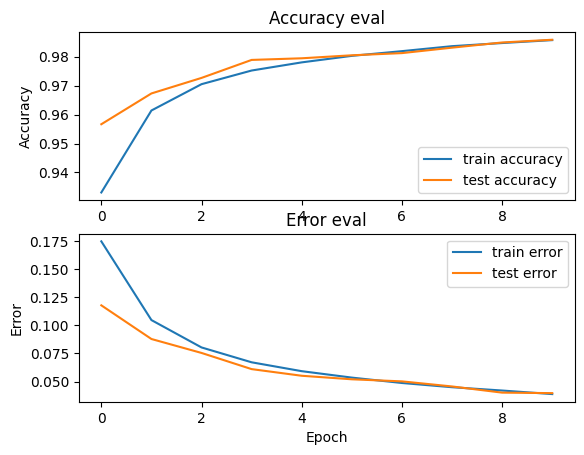

<Figure size 2880x2160 with 0 Axes>

In [19]:
if __name__ == "__main__":
    # create train, validation and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2, 0.05)
    batch_size = 64
    model = build_model()
    
    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
    model.build(input_shape=(None, 44, 13))
    model.summary()
    

    history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = 32, epochs = 10)
    
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
    print("Accuracy on test set is: {}".format(test_accuracy))
    
    # make prediction on a sample
    X = X_test[0]
    y = y_test[0]

    predict(model, X, y)
    
    # plot accuracy and error over the epochs
    plot_history(history)

In [22]:
model.save_weights('02_model/Vit.h5')
# model=keras.models.load_model('02_model/1121.h5')

In [31]:
model = build_model()
model.build(input_shape=(None, 44, 13))
model.load_weights('02_model/Vit.h5')
    

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 44, 13)]     0           []                               
                                                                                                  
 reshape_5 (Reshape)            (None, 11, 52)       0           ['input_6[0][0]']                
                                                                                                  
 dense_32 (Dense)               (None, 11, 64)       3392        ['reshape_5[0][0]']              
                                                                                                  
 layer_normalization_20 (LayerN  (None, 11, 64)      128         ['dense_32[0][0]']               
 ormalization)                                                                              

In [23]:
X_test_pre = model.predict(X_test)
y_pre = np.argmax(X_test_pre, axis = 1)
import sklearn.metrics as sm
matrixes = sm.confusion_matrix(y_test, y_pre)
print(matrixes)
report = sm.classification_report(y_test, y_pre)
print(report)

1660/1660 [==============================] - 6s 4ms/step
[[43498   272]
 [  467  8853]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43770
           1       0.97      0.95      0.96      9320

    accuracy                           0.99     53090
   macro avg       0.98      0.97      0.98     53090
weighted avg       0.99      0.99      0.99     53090



In [24]:
X_dev, y_dev = load_data("data_add_test.json")
y_dev_pre = np.argmax(model.predict(X_dev), axis = 1)
matrixes = sm.confusion_matrix(y_dev, y_dev_pre)
print(matrixes)
report = sm.classification_report(y_dev, y_dev_pre)
print(report)

8296/8296 [==============================] - 29s 3ms/step
[[218345    991]
 [  1943  44171]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    219336
           1       0.98      0.96      0.97     46114

    accuracy                           0.99    265450
   macro avg       0.98      0.98      0.98    265450
weighted avg       0.99      0.99      0.99    265450

